In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
import random 
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

In [2]:
import datetime 
import os.path  
import sys  

import backtrader as bt

In [3]:
df = pd.read_csv("./BTCUSDT20162018.csv", sep=',')

In [4]:
df.head()

,Open_time,Open,High,Low,Close,Volume
0,8/17/17 11:00,4261.48,4280.56,4261.48,4261.48,2.189061
1,8/17/17 11:15,4261.48,4270.41,4261.32,4261.45,9.119865
2,8/17/17 11:30,4280.00,4310.07,4267.99,4310.07,21.923552
3,8/17/17 11:45,4310.07,4313.62,4291.37,4308.83,13.948531
4,8/17/17 12:00,4308.83,4328.69,4304.31,4304.31,5.101153


In [5]:
df.dtypes

Open_time     object
Open         float64
High         float64
Low          float64
Close        float64
Volume       float64
dtype: object

In [15]:
# Create a Stratey
import random
p = .6
class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market

            # Not yet ... we MIGHT BUY if ...
        bool_val = random.uniform(0, 1) < p
        buy_sig = bool_val * self.dataclose[0]<self.dataclose[5]
        if buy_sig:
            self.log('BUY CREATE, %.2f'%self.dataclose[0])
            self.order = self.buy()
        else:
            self.log('SELL CREATE, %.2f'%self.dataclose[0])
            self.order = self.sell()

if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    cerebro.addstrategy(TestStrategy)

    data = bt.feeds.GenericCSVData(
        dataname='./BTCUSDT20162018.csv',

        fromdate=datetime.datetime(2017, 8, 17),
        todate=datetime.datetime(2018, 4, 9),

        nullvalue=0.0,

        dtformat=('%m/%d/%y %H:%M'),

        datetime=0,
        high=2,
        low=3,
        open=1,
        close=4,
        volume=5,
        openinterest=-1
)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(100000.0)

    # Set the commission - 0.1% ... divide by 100 to remove the %
    cerebro.broker.setcommission(commission=0.001)

    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    print('Profit: ', cerebro.broker.getvalue()/100000-1)

Starting Portfolio Value: 100000.00
2017-08-17, Close, 4261.48
2017-08-17, BUY CREATE, 4261.48
2017-08-17, Close, 4261.45
2017-08-17, Close, 4310.07
2017-08-17, Close, 4308.83
2017-08-17, Close, 4304.31
2017-08-17, Close, 4320.00
2017-08-17, Close, 4291.37
2017-08-17, Close, 4315.32
2017-08-17, Close, 4330.00
2017-08-17, Close, 4311.02
2017-08-17, Close, 4345.45
2017-08-17, Close, 4324.35
2017-08-17, Close, 4316.62
2017-08-17, Close, 4291.38
2017-08-17, Close, 4300.00
2017-08-17, Close, 4349.99
2017-08-17, Close, 4360.71
2017-08-17, Close, 4360.70
2017-08-17, Close, 4360.69
2017-08-17, Close, 4360.69
2017-08-17, Close, 4360.00
2017-08-17, Close, 4360.00
2017-08-17, Close, 4436.51
2017-08-17, Close, 4444.00
2017-08-17, Close, 4400.00
2017-08-17, Close, 4440.00
2017-08-17, Close, 4415.00
2017-08-17, Close, 4460.00
2017-08-17, Close, 4474.80
2017-08-17, Close, 4485.39
2017-08-17, Close, 4469.93
2017-08-17, Close, 4427.30
2017-08-17, Close, 4441.87
2017-08-17, Close, 4418.12
2017-08-17, Cl

2017-08-24, Close, 4117.07
2017-08-24, Close, 4079.03
2017-08-24, Close, 4090.00
2017-08-24, Close, 4105.00
2017-08-24, Close, 4118.40
2017-08-24, Close, 4125.41
2017-08-24, Close, 4118.00
2017-08-24, Close, 4116.06
2017-08-24, Close, 4090.00
2017-08-24, Close, 4095.18
2017-08-24, Close, 4089.18
2017-08-24, Close, 4117.00
2017-08-24, Close, 4114.20
2017-08-24, Close, 4147.00
2017-08-24, Close, 4147.88
2017-08-24, Close, 4133.50
2017-08-24, Close, 4114.01
2017-08-24, Close, 4133.00
2017-08-24, Close, 4153.68
2017-08-24, Close, 4153.60
2017-08-24, Close, 4131.00
2017-08-24, Close, 4114.01
2017-08-24, Close, 4141.41
2017-08-24, Close, 4194.09
2017-08-24, Close, 4140.91
2017-08-24, Close, 4201.10
2017-08-24, Close, 4155.82
2017-08-24, Close, 4156.11
2017-08-24, Close, 4131.92
2017-08-24, Close, 4113.79
2017-08-24, Close, 4130.00
2017-08-24, Close, 4113.49
2017-08-24, Close, 4113.58
2017-08-24, Close, 4100.06
2017-08-24, Close, 4112.49
2017-08-24, Close, 4090.39
2017-08-24, Close, 4113.98
2

2017-09-01, Close, 4745.32
2017-09-01, Close, 4749.99
2017-09-01, Close, 4731.01
2017-09-01, Close, 4742.46
2017-09-01, Close, 4735.98
2017-09-01, Close, 4766.01
2017-09-01, Close, 4766.00
2017-09-01, Close, 4761.42
2017-09-01, Close, 4770.38
2017-09-01, Close, 4766.07
2017-09-01, Close, 4738.89
2017-09-01, Close, 4775.00
2017-09-01, Close, 4780.00
2017-09-01, Close, 4780.00
2017-09-01, Close, 4780.00
2017-09-01, Close, 4793.00
2017-09-01, Close, 4795.00
2017-09-01, Close, 4777.41
2017-09-01, Close, 4781.34
2017-09-01, Close, 4777.02
2017-09-01, Close, 4740.01
2017-09-01, Close, 4740.00
2017-09-01, Close, 4748.93
2017-09-01, Close, 4725.81
2017-09-01, Close, 4769.07
2017-09-01, Close, 4746.94
2017-09-01, Close, 4787.81
2017-09-01, Close, 4803.83
2017-09-01, Close, 4780.00
2017-09-01, Close, 4769.85
2017-09-01, Close, 4764.87
2017-09-01, Close, 4780.80
2017-09-02, BUY EXECUTED, Price: 4776.93, Cost: 4776.93, Comm 4.78
2017-09-02, Close, 4758.86
2017-09-02, BUY CREATE, 4758.86
2017-09-02

2017-09-14, Close, 3499.99
2017-09-14, Close, 3518.00
2017-09-14, Close, 3523.52
2017-09-14, Close, 3508.99
2017-09-14, Close, 3499.78
2017-09-14, Close, 3460.00
2017-09-15, BUY EXECUTED, Price: 3459.99, Cost: 3459.99, Comm 3.46
2017-09-15, Close, 3406.96
2017-09-15, SELL CREATE, 3406.96
2017-09-15, Close, 3371.40
2017-09-15, Close, 3334.50
2017-09-15, Close, 3325.27
2017-09-15, Close, 3263.58
2017-09-15, Close, 3399.98
2017-09-15, Close, 3350.02
2017-09-15, Close, 3442.28
2017-09-15, Close, 3498.99
2017-09-15, Close, 3390.03
2017-09-15, Close, 3405.44
2017-09-15, Close, 3370.00
2017-09-15, Close, 3440.00
2017-09-15, Close, 3443.96
2017-09-15, Close, 3399.99
2017-09-15, Close, 3386.01
2017-09-15, Close, 3336.61
2017-09-15, Close, 3319.96
2017-09-15, Close, 3345.64
2017-09-15, Close, 3285.00
2017-09-15, Close, 3320.00
2017-09-15, Close, 3320.00
2017-09-15, Close, 3273.80
2017-09-15, Close, 3329.00
2017-09-15, Close, 3328.62
2017-09-15, Close, 3241.13
2017-09-15, Close, 3201.00
2017-09-1

2017-09-28, Close, 4199.99
2017-09-28, Close, 4198.00
2017-09-28, Close, 4199.99
2017-09-28, Close, 4187.99
2017-09-28, Close, 4180.01
2017-09-28, Close, 4164.01
2017-09-28, Close, 4160.00
2017-09-28, Close, 4170.00
2017-09-28, Close, 4160.00
2017-09-28, Close, 4179.06
2017-09-28, Close, 4181.91
2017-09-28, Close, 4200.00
2017-09-28, Close, 4202.00
2017-09-28, Close, 4185.02
2017-09-28, Close, 4250.90
2017-09-28, Close, 4242.01
2017-09-28, Close, 4260.00
2017-09-28, Close, 4262.00
2017-09-28, Close, 4250.53
2017-09-28, Close, 4230.00
2017-09-28, Close, 4243.01
2017-09-28, Close, 4241.00
2017-09-28, Close, 4238.00
2017-09-28, Close, 4235.01
2017-09-28, Close, 4244.00
2017-09-28, Close, 4248.00
2017-09-28, Close, 4238.06
2017-09-28, Close, 4246.00
2017-09-28, Close, 4249.00
2017-09-28, Close, 4260.00
2017-09-28, Close, 4250.01
2017-09-28, Close, 4267.89
2017-09-28, Close, 4251.11
2017-09-28, Close, 4251.01
2017-09-28, Close, 4256.00
2017-09-28, Close, 4256.56
2017-09-28, Close, 4230.09
2

2017-10-11, Close, 4880.00
2017-10-11, Close, 4885.00
2017-10-11, Close, 4881.98
2017-10-11, Close, 4865.39
2017-10-11, Close, 4847.00
2017-10-11, Close, 4819.21
2017-10-11, Close, 4780.00
2017-10-11, Close, 4795.00
2017-10-11, Close, 4796.00
2017-10-11, Close, 4740.00
2017-10-11, Close, 4773.02
2017-10-11, Close, 4783.06
2017-10-11, Close, 4772.02
2017-10-11, Close, 4779.04
2017-10-11, Close, 4814.00
2017-10-11, Close, 4765.99
2017-10-11, Close, 4766.00
2017-10-11, Close, 4757.00
2017-10-11, Close, 4760.00
2017-10-11, Close, 4780.05
2017-10-11, Close, 4780.00
2017-10-11, Close, 4792.94
2017-10-11, Close, 4792.96
2017-10-11, Close, 4814.76
2017-10-11, Close, 4781.00
2017-10-11, Close, 4750.01
2017-10-11, Close, 4778.00
2017-10-11, Close, 4753.16
2017-10-11, Close, 4752.94
2017-10-11, Close, 4739.89
2017-10-11, Close, 4750.00
2017-10-11, Close, 4746.00
2017-10-11, Close, 4750.00
2017-10-11, Close, 4761.93
2017-10-11, Close, 4797.99
2017-10-11, Close, 4750.05
2017-10-11, Close, 4789.99
2

2017-10-24, Close, 5735.01
2017-10-24, Close, 5690.78
2017-10-24, Close, 5665.98
2017-10-24, Close, 5658.12
2017-10-24, Close, 5680.52
2017-10-24, Close, 5630.07
2017-10-24, Close, 5601.01
2017-10-24, Close, 5633.06
2017-10-24, Close, 5645.52
2017-10-24, Close, 5635.23
2017-10-24, Close, 5649.98
2017-10-24, Close, 5675.00
2017-10-24, Close, 5687.99
2017-10-24, Close, 5666.94
2017-10-24, Close, 5680.00
2017-10-24, Close, 5676.04
2017-10-24, Close, 5666.15
2017-10-24, Close, 5610.97
2017-10-24, Close, 5637.98
2017-10-24, Close, 5629.00
2017-10-24, Close, 5610.00
2017-10-24, Close, 5590.63
2017-10-24, Close, 5618.27
2017-10-24, Close, 5613.07
2017-10-24, Close, 5616.02
2017-10-24, Close, 5616.01
2017-10-24, Close, 5615.92
2017-10-24, Close, 5615.92
2017-10-24, Close, 5611.01
2017-10-24, Close, 5623.04
2017-10-24, Close, 5637.65
2017-10-24, Close, 5637.96
2017-10-24, Close, 5675.02
2017-10-24, Close, 5696.99
2017-10-24, Close, 5678.06
2017-10-24, Close, 5719.02
2017-10-25, SELL EXECUTED, P

2017-11-08, Close, 7313.99
2017-11-08, Close, 7330.00
2017-11-08, Close, 7310.00
2017-11-08, Close, 7300.06
2017-11-08, Close, 7312.29
2017-11-08, Close, 7357.97
2017-11-08, Close, 7365.02
2017-11-08, Close, 7377.04
2017-11-08, Close, 7377.00
2017-11-08, Close, 7369.98
2017-11-08, Close, 7332.88
2017-11-08, Close, 7307.06
2017-11-08, Close, 7300.01
2017-11-08, Close, 7303.01
2017-11-08, Close, 7304.02
2017-11-08, Close, 7333.00
2017-11-08, Close, 7344.75
2017-11-08, Close, 7336.71
2017-11-08, Close, 7358.98
2017-11-08, Close, 7320.02
2017-11-08, Close, 7314.98
2017-11-08, Close, 7325.03
2017-11-08, Close, 7347.93
2017-11-08, Close, 7340.04
2017-11-08, Close, 7341.00
2017-11-08, Close, 7339.83
2017-11-08, Close, 7364.00
2017-11-08, Close, 7375.99
2017-11-08, Close, 7399.96
2017-11-08, Close, 7396.00
2017-11-08, Close, 7404.90
2017-11-08, Close, 7450.01
2017-11-08, Close, 7400.00
2017-11-08, Close, 7400.00
2017-11-08, Close, 7389.98
2017-11-08, Close, 7400.00
2017-11-08, Close, 7434.32
2

2017-11-21, Close, 8160.45
2017-11-21, Close, 8180.03
2017-11-21, Close, 8200.00
2017-11-21, Close, 8238.80
2017-11-21, Close, 8207.22
2017-11-21, Close, 8238.81
2017-11-21, Close, 8229.04
2017-11-21, Close, 8214.00
2017-11-21, Close, 8215.20
2017-11-21, Close, 8231.86
2017-11-21, Close, 8245.03
2017-11-21, Close, 8241.06
2017-11-21, Close, 8245.06
2017-11-21, Close, 8289.93
2017-11-21, Close, 8279.96
2017-11-21, Close, 8226.52
2017-11-21, Close, 8240.21
2017-11-21, Close, 8245.00
2017-11-21, Close, 8244.98
2017-11-21, Close, 8224.31
2017-11-21, Close, 8220.04
2017-11-21, Close, 8240.00
2017-11-21, Close, 8291.02
2017-11-21, Close, 8363.00
2017-11-21, Close, 8363.88
2017-11-21, Close, 8385.02
2017-11-21, Close, 8388.83
2017-11-21, Close, 8370.01
2017-11-21, Close, 8370.13
2017-11-21, Close, 8369.98
2017-11-21, Close, 8367.46
2017-11-21, Close, 8287.89
2017-11-22, BUY EXECUTED, Price: 8287.82, Cost: 8287.82, Comm 8.29
2017-11-22, Close, 8316.96
2017-11-22, SELL CREATE, 8316.96
2017-11-2

2017-12-04, Close, 11251.00
2017-12-04, Close, 11250.00
2017-12-04, Close, 11276.03
2017-12-04, Close, 11350.00
2017-12-04, Close, 11297.42
2017-12-04, Close, 11310.08
2017-12-04, Close, 11369.96
2017-12-04, Close, 11422.81
2017-12-04, Close, 11470.00
2017-12-04, Close, 11498.53
2017-12-04, Close, 11510.00
2017-12-04, Close, 11510.99
2017-12-04, Close, 11400.00
2017-12-04, Close, 11430.31
2017-12-04, Close, 11459.98
2017-12-04, Close, 11478.00
2017-12-04, Close, 11478.00
2017-12-04, Close, 11478.00
2017-12-04, Close, 11435.00
2017-12-04, Close, 11400.01
2017-12-04, Close, 11479.59
2017-12-04, Close, 11512.14
2017-12-04, Close, 11544.76
2017-12-04, Close, 11498.48
2017-12-04, Close, 11572.00
2017-12-04, Close, 11539.78
2017-12-04, Close, 11496.34
2017-12-04, Close, 11400.00
2017-12-04, Close, 11470.77
2017-12-04, Close, 11464.00
2017-12-04, Close, 11346.81
2017-12-04, Close, 11270.60
2017-12-04, Close, 11304.10
2017-12-04, Close, 11295.69
2017-12-04, Close, 11339.58
2017-12-04, Close, 1

2017-12-17, Close, 19756.02
2017-12-17, Close, 19662.86
2017-12-17, Close, 19560.49
2017-12-17, Close, 19358.00
2017-12-17, Close, 19412.82
2017-12-17, Close, 19505.98
2017-12-17, Close, 19539.99
2017-12-17, Close, 19540.02
2017-12-17, Close, 19520.00
2017-12-17, Close, 19450.00
2017-12-17, Close, 19461.80
2017-12-17, Close, 19235.00
2017-12-17, Close, 19248.29
2017-12-17, Close, 18940.00
2017-12-17, Close, 19160.23
2017-12-17, Close, 19220.00
2017-12-17, Close, 19329.80
2017-12-17, Close, 19050.00
2017-12-17, Close, 19128.49
2017-12-17, Close, 18950.00
2017-12-18, SELL EXECUTED, Price: 18946.66, Cost: 8719.46, Comm 18.95
2017-12-18, Close, 19101.24
2017-12-18, BUY CREATE, 19101.24
2017-12-18, Close, 19070.01
2017-12-18, Close, 19173.14
2017-12-18, Close, 19130.00
2017-12-18, Close, 18929.98
2017-12-18, Close, 19000.00
2017-12-18, Close, 18909.54
2017-12-18, Close, 18742.00
2017-12-18, Close, 18718.27
2017-12-18, Close, 18607.00
2017-12-18, Close, 18537.00
2017-12-18, Close, 18845.91
2

2018-01-01, Close, 14010.00
2018-01-01, Close, 13971.95
2018-01-01, Close, 13942.27
2018-01-01, Close, 13920.03
2018-01-01, Close, 13915.22
2018-01-01, Close, 13940.99
2018-01-01, Close, 13911.00
2018-01-01, Close, 13898.98
2018-01-01, Close, 13899.93
2018-01-01, Close, 13820.50
2018-01-01, Close, 13733.71
2018-01-01, Close, 13724.00
2018-01-01, Close, 13755.27
2018-01-01, Close, 13716.36
2018-01-01, Close, 13556.15
2018-01-01, Close, 13521.12
2018-01-01, Close, 13470.41
2018-01-01, Close, 13529.01
2018-01-01, Close, 13445.63
2018-01-01, Close, 13560.00
2018-01-01, Close, 13440.01
2018-01-01, Close, 13203.06
2018-01-01, Close, 13387.00
2018-01-01, Close, 13225.00
2018-01-01, Close, 13321.08
2018-01-01, Close, 13330.18
2018-01-01, Close, 13444.99
2018-01-01, Close, 13562.37
2018-01-01, Close, 13500.00
2018-01-01, Close, 13410.03
2018-01-01, Close, 13351.71
2018-01-01, Close, 13430.00
2018-01-01, Close, 13507.41
2018-01-01, Close, 13601.01
2018-01-01, Close, 13627.14
2018-01-01, Close, 1

2018-01-15, Close, 13355.00
2018-01-15, Close, 13449.79
2018-01-15, Close, 13451.96
2018-01-15, Close, 13378.00
2018-01-15, Close, 13381.10
2018-01-15, Close, 13410.05
2018-01-15, Close, 13394.98
2018-01-15, Close, 13560.00
2018-01-15, Close, 13532.01
2018-01-15, Close, 13664.97
2018-01-15, Close, 13672.63
2018-01-15, Close, 13659.99
2018-01-15, Close, 13650.00
2018-01-15, Close, 13637.55
2018-01-15, Close, 13386.88
2018-01-15, Close, 13511.49
2018-01-15, Close, 13644.90
2018-01-15, Close, 13559.95
2018-01-15, Close, 13570.63
2018-01-15, Close, 13903.99
2018-01-15, Close, 14195.00
2018-01-15, Close, 14100.83
2018-01-15, Close, 13973.72
2018-01-15, Close, 14050.00
2018-01-15, Close, 14085.48
2018-01-15, Close, 14179.01
2018-01-15, Close, 14220.92
2018-01-15, Close, 14083.60
2018-01-15, Close, 14038.08
2018-01-15, Close, 14024.01
2018-01-15, Close, 14072.97
2018-01-15, Close, 13946.09
2018-01-15, Close, 13990.01
2018-01-15, Close, 13915.13
2018-01-15, Close, 13877.02
2018-01-15, Close, 1

2018-01-29, Close, 11261.38
2018-01-29, Close, 11279.99
2018-01-29, Close, 11281.92
2018-01-29, Close, 11227.00
2018-01-29, Close, 11261.01
2018-01-29, Close, 11255.21
2018-01-29, Close, 11263.99
2018-01-29, Close, 11294.00
2018-01-29, Close, 11294.90
2018-01-29, Close, 11359.47
2018-01-29, Close, 11381.20
2018-01-29, Close, 11410.01
2018-01-29, Close, 11379.96
2018-01-29, Close, 11384.98
2018-01-29, Close, 11390.02
2018-01-29, Close, 11321.54
2018-01-29, Close, 11330.94
2018-01-29, Close, 11383.91
2018-01-29, Close, 11385.65
2018-01-29, Close, 11383.95
2018-01-29, Close, 11350.00
2018-01-29, Close, 11396.01
2018-01-30, BUY EXECUTED, Price: 11397.00, Cost: 11397.00, Comm 11.40
2018-01-30, Close, 11400.00
2018-01-30, BUY CREATE, 11400.00
2018-01-30, Order Canceled/Margin/Rejected
2018-01-30, Close, 11392.37
2018-01-30, SELL CREATE, 11392.37
2018-01-30, Close, 11420.00
2018-01-30, Close, 11422.51
2018-01-30, Close, 11350.00
2018-01-30, Close, 11368.00
2018-01-30, Close, 11360.32
2018-01-

2018-02-12, Close, 8532.00
2018-02-12, Close, 8512.01
2018-02-12, Close, 8473.76
2018-02-12, Close, 8700.90
2018-02-12, Close, 8737.77
2018-02-12, Close, 8776.10
2018-02-12, Close, 8758.00
2018-02-12, Close, 8779.88
2018-02-12, Close, 8689.00
2018-02-12, Close, 8751.73
2018-02-12, Close, 8768.43
2018-02-12, Close, 8740.00
2018-02-12, Close, 8729.57
2018-02-12, Close, 8790.00
2018-02-12, Close, 8823.93
2018-02-12, Close, 8811.00
2018-02-12, Close, 8686.00
2018-02-12, Close, 8653.97
2018-02-12, Close, 8640.01
2018-02-12, Close, 8691.17
2018-02-12, Close, 8709.99
2018-02-12, Close, 8710.86
2018-02-12, Close, 8760.00
2018-02-12, Close, 8705.14
2018-02-12, Close, 8735.03
2018-02-12, Close, 8677.50
2018-02-12, Close, 8670.75
2018-02-12, Close, 8683.00
2018-02-12, Close, 8536.00
2018-02-12, Close, 8520.00
2018-02-12, Close, 8529.59
2018-02-12, Close, 8615.00
2018-02-12, Close, 8612.00
2018-02-12, Close, 8600.60
2018-02-12, Close, 8670.00
2018-02-12, Close, 8714.00
2018-02-12, Close, 8693.00
2

2018-02-27, Close, 10195.00
2018-02-27, Close, 10139.50
2018-02-27, Close, 10180.23
2018-02-27, Close, 10200.00
2018-02-27, Close, 10149.64
2018-02-27, Close, 10191.77
2018-02-27, Close, 10247.98
2018-02-27, Close, 10293.52
2018-02-27, Close, 10270.00
2018-02-27, Close, 10276.94
2018-02-27, Close, 10292.69
2018-02-27, Close, 10284.00
2018-02-27, Close, 10311.99
2018-02-27, Close, 10242.75
2018-02-27, Close, 10250.00
2018-02-27, Close, 10309.61
2018-02-27, Close, 10323.15
2018-02-27, Close, 10344.00
2018-02-27, Close, 10263.00
2018-02-27, Close, 10309.00
2018-02-27, Close, 10306.00
2018-02-27, Close, 10345.00
2018-02-27, Close, 10327.00
2018-02-27, Close, 10344.17
2018-02-27, Close, 10600.00
2018-02-27, Close, 10706.22
2018-02-27, Close, 10682.00
2018-02-27, Close, 10695.51
2018-02-27, Close, 10700.00
2018-02-27, Close, 10680.00
2018-02-27, Close, 10713.00
2018-02-27, Close, 10724.00
2018-02-27, Close, 10735.02
2018-02-27, Close, 10706.56
2018-02-27, Close, 10647.59
2018-02-27, Close, 1

2018-03-12, Close, 9618.15
2018-03-12, Close, 9570.00
2018-03-12, Close, 9519.00
2018-03-12, Close, 9720.75
2018-03-12, Close, 9648.94
2018-03-12, Close, 9575.00
2018-03-12, Close, 9521.05
2018-03-12, Close, 9550.05
2018-03-12, Close, 9463.39
2018-03-12, Close, 9484.02
2018-03-12, Close, 9533.57
2018-03-12, Close, 9607.99
2018-03-12, Close, 9591.16
2018-03-12, Close, 9610.00
2018-03-12, Close, 9608.87
2018-03-12, Close, 9680.00
2018-03-12, Close, 9652.75
2018-03-12, Close, 9489.13
2018-03-12, Close, 9556.95
2018-03-12, Close, 9546.79
2018-03-12, Close, 9599.00
2018-03-12, Close, 9576.89
2018-03-12, Close, 9585.00
2018-03-12, Close, 9577.66
2018-03-12, Close, 9537.94
2018-03-12, Close, 9380.09
2018-03-12, Close, 9416.09
2018-03-12, Close, 9386.01
2018-03-12, Close, 9514.99
2018-03-12, Close, 9540.00
2018-03-12, Close, 9537.00
2018-03-12, Close, 9489.99
2018-03-12, Close, 9576.79
2018-03-12, Close, 9564.00
2018-03-12, Close, 9550.00
2018-03-12, Close, 9548.93
2018-03-12, Close, 9636.05
2

2018-03-25, Close, 8523.01
2018-03-25, Close, 8465.03
2018-03-25, Close, 8476.23
2018-03-25, Close, 8500.00
2018-03-25, Close, 8545.00
2018-03-25, Close, 8555.58
2018-03-25, Close, 8524.99
2018-03-25, Close, 8511.00
2018-03-25, Close, 8549.13
2018-03-25, Close, 8524.59
2018-03-25, Close, 8562.39
2018-03-25, Close, 8563.09
2018-03-25, Close, 8553.60
2018-03-25, Close, 8521.00
2018-03-25, Close, 8550.65
2018-03-25, Close, 8547.45
2018-03-25, Close, 8527.01
2018-03-25, Close, 8497.32
2018-03-25, Close, 8440.00
2018-03-25, Close, 8417.00
2018-03-25, Close, 8464.78
2018-03-25, Close, 8466.53
2018-03-25, Close, 8544.96
2018-03-25, Close, 8547.01
2018-03-25, Close, 8529.28
2018-03-25, Close, 8524.00
2018-03-25, Close, 8497.20
2018-03-25, Close, 8495.57
2018-03-25, Close, 8532.80
2018-03-25, Close, 8503.00
2018-03-25, Close, 8500.00
2018-03-25, Close, 8438.30
2018-03-25, Close, 8456.71
2018-03-25, Close, 8470.00
2018-03-25, Close, 8451.93
2018-03-25, Close, 8428.00
2018-03-25, Close, 8380.45
2

/Users/admin/anaconda/lib/python3.6/site-packages/backtrader/plot/__init__.py:30: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/admin/anaconda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/admin/anaconda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/admin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/admin/anaconda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/admin/anaconda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start


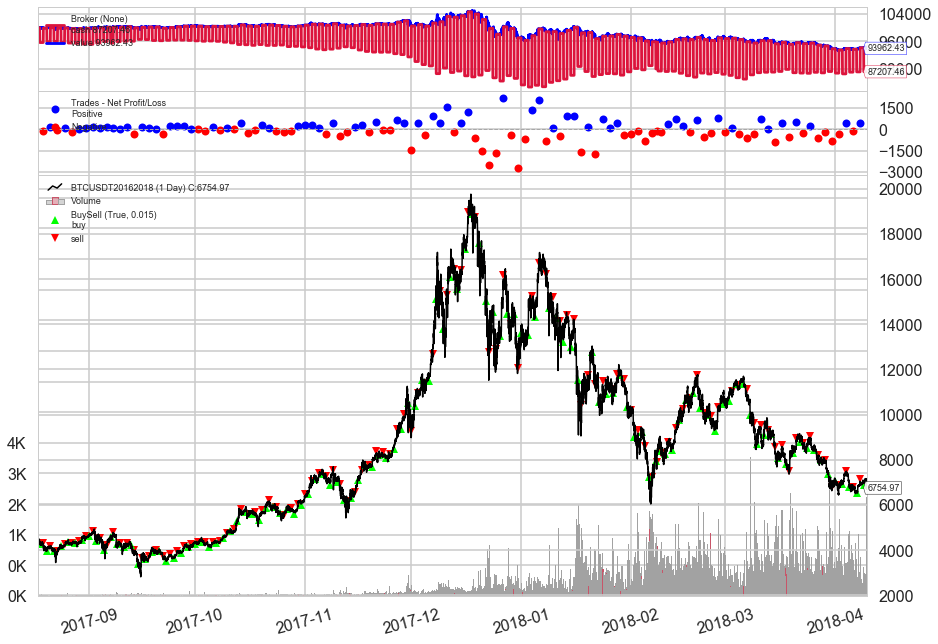

[[<matplotlib.figure.Figure at 0x11bb7cc50>]]

In [7]:
cerebro.plot()